# SEQ Task

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')

#20 subjects
sids = ['783126', '783127', '783130', '783131', '783132', '783133', '783135', '783136', '783137', '783138', 
        '783139', '783144', '783146', '783148', '783149', '783150', '783152', '783153', '783155', '783158'] 

proj_dir = '/home/data/madlab/data/mri/seqtrd' 
mask_filenames = []
cope_files = []
for SID in sids:
    subjmasks = glob(proj_dir + '/mask/cortical_rois/{0}/anat_masks/_subject_id_{0}/*'.format(SID))
    mask_filenames.append(sorted(subjmasks))
    subjcopes = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' 
                     + SID + '/seq_1stpos_cic_bl/fixedfx/cope*.nii.gz')
    cope_files.append(sorted(subjcopes))   
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 32:
        print(SID)

/home/data/madlab/envs/seqtrd_madlab_env/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/home/data/madlab/envs/seqtrd_madlab_env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Cell to double-check the array indexing

In [2]:
test_sub = 0
for i, curr_mask in enumerate(mask_filenames[test_sub]):
    print(i, mask_filenames[test_sub][i].split('/')[-1][:-7])

(0, 'cerebellum_bimask_warped')
(1, 'l_ant_hpc_warped')
(2, 'l_cerebellum_bimask_warped')
(3, 'lh-angular-gyrus_fs_warped')
(4, 'lh-caudate_warped')
(5, 'lh-motor_fs_warped')
(6, 'lh-pcc_fs_warped')
(7, 'lh-precuneus_fs_warped')
(8, 'lh-superiortemporalctx_warped')
(9, 'lh_hpc_warped')
(10, 'lh_mpfc_warped')
(11, 'limbicthal_bin_trans_warped')
(12, 'r_ant_hpc_warped')
(13, 'r_cerebellum_bimask_warped')
(14, 'rh-angular-gyrus_fs_warped')
(15, 'rh-caudate_warped')
(16, 'rh-motor_fs_warped')
(17, 'rh-pcc_fs_warped')
(18, 'rh-precuneus_fs_warped')
(19, 'rh-superiortemporalctx_warped')
(20, 'rh_hpc_warped')
(21, 'rh_mpfc_warped')
(22, 'seq_bold_r01_dtype_despike_roi')
(23, 'x_bihemi_mpfc_warped')
(24, 'x_combined_antHC_mPFC_mask')


In [3]:
for i, curr_cope in enumerate(cope_files[1]):
    print(i, cope_files[1][i].split('/')[-1][5:-7]) 

(0, 'InseqCorr_minus_InseqIncorr')
(1, 'InseqCorr_minus_OTCorr')
(2, 'InseqCorr_minus_OTIncorr')
(3, 'InseqCorr_minus_OutseqCorr')
(4, 'InseqCorr_minus_RepeatCorr')
(5, 'InseqCorr_minus_RepeatIncorr')
(6, 'InseqCorr_minus_SkipCorr')
(7, 'InseqCorr_minus_SkipIncorr')
(8, 'InseqIncorr_minus_InseqCorr')
(9, 'InseqIncorr_minus_OutseqIncorr')
(10, 'OTCorr_minu_InseqCorr')
(11, 'OTCorr_minus_OTIncorr')
(12, 'OTIncorr_minus_InseqCorr')
(13, 'OTIncorr_minus_OTCorr')
(14, 'OutseqCorr_minus_InseqCorr')
(15, 'OutseqIncorr_minus_InseqIncorr')
(16, 'RepeatCorr_minu_InseqCorr')
(17, 'RepeatCorr_minus_RepeatIncorr')
(18, 'RepeatIncorr_minus_InseqCorr')
(19, 'RepeatIncorr_minus_RepeatCorr')
(20, 'SkipCorr_minu_InseqCorr')
(21, 'SkipCorr_minus_SkipIncorr')
(22, 'SkipIncorr_minus_InseqCorr')
(23, 'inseq_corr')
(24, 'inseq_incorr')
(25, 'ot_corr')
(26, 'ot_incorr')
(27, 'repeat_corr')
(28, 'repeat_incorr')
(29, 'skipIncorr_minus_SkipCorr')
(30, 'skip_corr')
(31, 'skip_incorr')


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
trials = {"mpfc_inseq":[], "mpfc_ot":[], "mpfc_skip":[], "mpfc_repeat":[],
          "hpc_inseq":[], "hpc_ot":[], "hpc_skip":[], "hpc_repeat":[],
          "pcc_inseq":[], "pcc_ot":[], "pcc_skip":[], "pcc_repeat":[],
          "pre_inseq":[], "pre_ot":[], "pre_skip":[], "pre_repeat":[]}
                     
for i in range(len(sids)):
    lh_mpfc_img = nb.load(mask_filenames[i][10])
    rh_mpfc_img = nb.load(mask_filenames[i][21])
    lh_hpc_img = nb.load(mask_filenames[i][1])
    rh_hpc_img = nb.load(mask_filenames[i][12])
    lh_pcc_img = nb.load(mask_filenames[i][6])
    rh_pcc_img = nb.load(mask_filenames[i][17])
    lh_pre_img = nb.load(mask_filenames[i][7])
    rh_pre_img = nb.load(mask_filenames[i][18])
    
    inseq_img = nb.load(cope_files[i][8])
    ot_img = nb.load(cope_files[i][13])
    repeat_img = nb.load(cope_files[i][19])
    skip_img = nb.load(cope_files[i][29])
 
    for d in ['inseq', 'ot', 'repeat', 'skip']:
        for r in ['hpc', 'mpfc', 'pcc', 'pre']:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(d,r))   
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(d,r))
            bihemi_data = np.concatenate((lh_data, rh_data))
            eval('trials["{0}_{1}"].append(np.mean(bihemi_data))'.format(r,d))
                                
trials_df = pd.DataFrame(trials) 

In [5]:
trials_df

,hpc_inseq,hpc_ot,hpc_repeat,hpc_skip,mpfc_inseq,mpfc_ot,mpfc_repeat,mpfc_skip,pcc_inseq,pcc_ot,pcc_repeat,pcc_skip,pre_inseq,pre_ot,pre_repeat,pre_skip
0,1.355048,1.505396,1.685199,-0.262727,1.322996,2.793470,-0.218787,0.910522,0.483292,0.914147,1.380820,-0.366975,0.328319,0.444363,0.434791,-1.252080
1,0.990139,-0.147205,0.628609,0.228212,0.447292,0.426257,-0.224109,0.527409,0.287852,0.074003,0.123465,0.874584,0.494347,0.815294,-0.058237,-0.696073
2,-1.022314,0.193716,-1.419177,1.214446,1.176502,1.812114,-1.139274,2.216021,0.332775,1.566865,-0.506375,1.927834,0.939534,0.332101,-0.843077,2.980056
3,0.608802,-0.350060,-0.177719,-1.169445,1.072991,5.675395,-0.543310,0.681327,0.141173,5.137949,-0.132772,-0.093813,0.595888,4.178319,-0.700104,0.121370
4,-2.389058,-0.327605,-1.061337,-1.066785,-2.339415,1.615722,-0.144830,0.954804,-0.941362,1.025937,1.081808,1.241521,-1.858987,1.977247,2.323629,0.837383
5,-0.911364,-2.036729,0.325725,-0.944674,0.511317,3.946411,3.823656,1.508878,-0.450033,2.484619,1.380433,-0.105095,1.251068,2.835245,1.807099,1.147759
6,0.792996,-1.923884,-1.676227,-0.496899,0.760651,1.051018,-2.961540,-0.420773,-0.931625,1.977716,-1.929648,0.985797,1.060595,2.115136,-1.784733,0.433128
7,0.058814,1.113127,-0.858913,-1.196629,-0.399163,1.614957,-0.280520,-1.147109,-0.849981,-0.012861,0.478223,-1.032341,-1.028379,-0.608399,-0.083202,-1.249548
8,0.196038,0.284052,1.148882,-0.702365,0.055142,0.080602,-0.203816,1.055518,-0.875137,0.843003,-0.101209,2.717546,-0.522128,-0.921200,-1.462500,1.705508
9,-1.607719,0.460632,0.490571,2.273996,-1.760649,0.850430,1.206359,2.959211,-1.884004,1.040106,1.353924,3.864947,-2.522243,1.410449,2.338993,5.080822


# Ordinal Transfers

Mean hpc_ot:  -0.22568759173154831
STD hpc_ot:  1.3706102784972156
Shapiro's Test of Normality: (0.8927536606788635, 0.030226288363337517)
--------
Mean mpfc_ot:  1.06926854737103
STD mpfc_ot:  1.7565972265112297
Shapiro's Test of Normality: (0.95887291431427, 0.5215865969657898)
--------
Mean pcc_ot:  1.0525683104526251
STD pcc_ot:  2.2054061628932606
Shapiro's Test of Normality: (0.8674839735031128, 0.01061494555324316)
--------
Mean pre_ot:  0.892205286026001
STD pre_ot:  2.097723655753936
Shapiro's Test of Normality: (0.8981800079345703, 0.03812770918011665)
--------
Ttest_relResult(statistic=2.9001627398556082, pvalue=0.009175407144165523) **


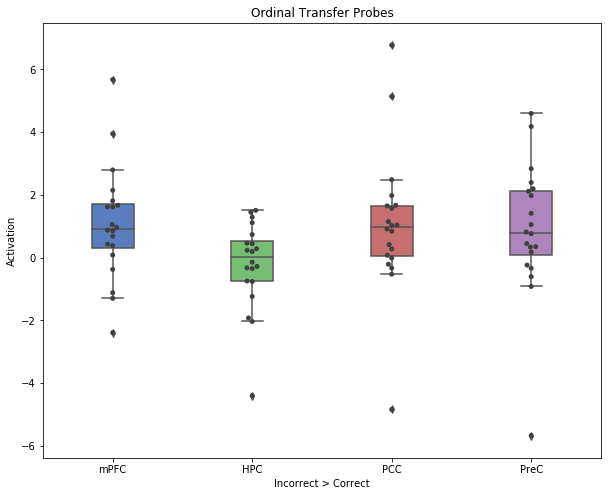

In [6]:
for key in trials_df:
    if "ot" in key:
        print "Mean {0}: ".format(key), np.mean(trials_df['{0}'.format(key)])
        print "STD {0}: ".format(key), np.std(trials_df['{0}'.format(key)])
        print "Shapiro's Test of Normality:", stats.shapiro(trials_df['{0}'.format(key)])
        print "--------"
print stats.ttest_rel(trials_df['mpfc_ot'], trials_df['hpc_ot']), "**"
N = 4
conditions = ['mPFC', 'HPC', 'PCC', 'PreC']
mpfc_allsubjs = [trials_df['mpfc_ot'], trials_df['hpc_ot'], 
                 trials_df['pcc_ot'], trials_df['pre_ot']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))
ax0 = sns.boxplot(data = mpfc_allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_title("Ordinal Transfer Probes")
ax.set_xlabel("Incorrect > Correct")
ax.set_ylabel("Activation")
plt.show()

# Repeats

Mean hpc_repeat:  -0.31503239944577216
STD hpc_repeat:  1.009166945943425
Shapiro's Test of Normality: (0.9634532928466797, 0.6148933172225952)
--------
Mean mpfc_repeat:  0.24325420409440995
STD mpfc_repeat:  1.512651408639495
Shapiro's Test of Normality: (0.9553058743476868, 0.4548211991786957)
--------
Mean pcc_repeat:  -0.033079918846488
STD pcc_repeat:  1.5846242994992124
Shapiro's Test of Normality: (0.9048409461975098, 0.05086880177259445)
--------
Mean pre_repeat:  -0.3344672184437513
STD pre_repeat:  1.8381802077133955
Shapiro's Test of Normality: (0.9311800003051758, 0.1627025604248047)
--------
Ttest_relResult(statistic=1.621334581053482, pvalue=0.12142335612710123)


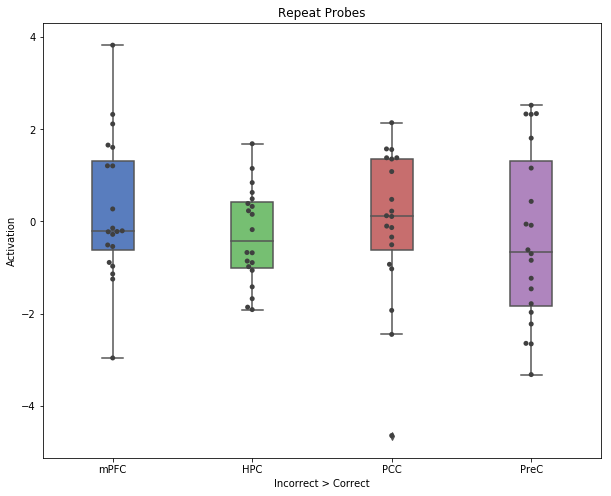

In [7]:
for key in trials_df:
    if "repeat" in key:
        print "Mean {0}: ".format(key), np.mean(trials_df['{0}'.format(key)])
        print "STD {0}: ".format(key), np.std(trials_df['{0}'.format(key)])
        print "Shapiro's Test of Normality:", stats.shapiro(trials_df['{0}'.format(key)])
        print "--------"
print stats.ttest_rel(trials_df['mpfc_repeat'], trials_df['hpc_repeat'])
N = 4
conditions = ['mPFC', 'HPC', 'PCC', 'PreC']
mpfc_allsubjs = [trials_df['mpfc_repeat'], trials_df['hpc_repeat'], 
                 trials_df['pcc_repeat'], trials_df['pre_repeat']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))
ax0 = sns.boxplot(data = mpfc_allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_title("Repeat Probes")
ax.set_xlabel("Incorrect > Correct")
ax.set_ylabel("Activation")
plt.show()

# Skips

Mean hpc_skip:  -0.37130845952779057
STD hpc_skip:  0.8539467353252426
Shapiro's Test of Normality: (0.8437992334365845, 0.0042035384103655815)
--------
Mean mpfc_skip:  0.6123271226882935
STD mpfc_skip:  0.9957149491280229
Shapiro's Test of Normality: (0.9731857776641846, 0.8202086687088013)
--------
Mean pcc_skip:  0.4631248593330383
STD pcc_skip:  1.4002228972614854
Shapiro's Test of Normality: (0.9558812379837036, 0.4651859998703003)
--------
Mean pre_skip:  0.35626820623874667
STD pre_skip:  1.7683530234072204
Shapiro's Test of Normality: (0.959053099155426, 0.5251098871231079)
--------
Ttest_relResult(statistic=5.5630070637593025, pvalue=2.2970025679896278e-05) **


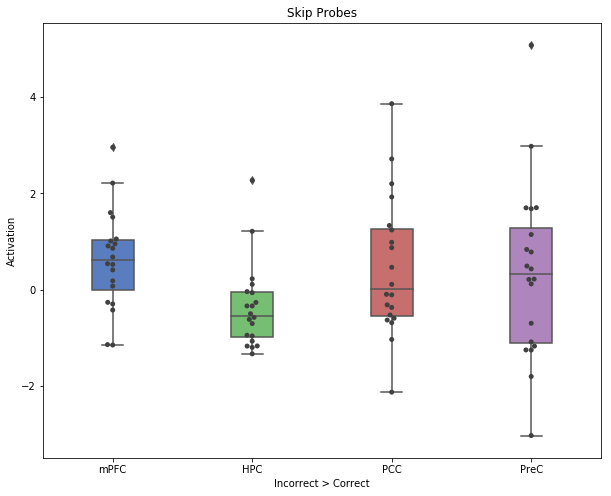

In [8]:
for key in trials_df:
    if "skip" in key:
        print "Mean {0}: ".format(key), np.mean(trials_df['{0}'.format(key)])
        print "STD {0}: ".format(key), np.std(trials_df['{0}'.format(key)])
        print "Shapiro's Test of Normality:", stats.shapiro(trials_df['{0}'.format(key)])
        print "--------"
print stats.ttest_rel(trials_df['mpfc_skip'], trials_df['hpc_skip']), "**"
N = 4
conditions = ['mPFC', 'HPC', 'PCC', 'PreC']
allsubjs = [trials_df['mpfc_skip'], trials_df['hpc_skip'], 
            trials_df['pcc_skip'], trials_df['pre_skip']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))
ax0 = sns.boxplot(data = allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_title("Skip Probes")
ax.set_xlabel("Incorrect > Correct")
ax.set_ylabel("Activation")
plt.show()

# Inseq Trials

Mean hpc_inseq:  -0.21472352799028158
STD hpc_inseq:  0.9546577126465953
Shapiro's Test of Normality: (0.9730709195137024, 0.8179407715797424)
--------
Mean mpfc_inseq:  0.18200744446367026
STD mpfc_inseq:  1.20354325852727
Shapiro's Test of Normality: (0.9379110336303711, 0.21888020634651184)
--------
Mean pcc_inseq:  -0.14577571265399455
STD pcc_inseq:  1.1430801085263531
Shapiro's Test of Normality: (0.959174633026123, 0.5274952054023743)
--------
Mean pre_inseq:  0.015073397196829319
STD pre_inseq:  1.1219914210630466
Shapiro's Test of Normality: (0.9061679244041443, 0.05389717221260071)
--------


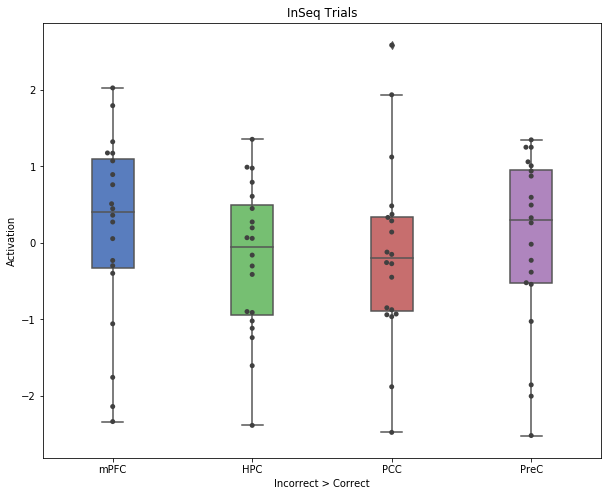

In [9]:
for key in trials_df:
    if "inseq" in key:
        print "Mean {0}: ".format(key), np.mean(trials_df['{0}'.format(key)])
        print "STD {0}: ".format(key), np.std(trials_df['{0}'.format(key)])
        print "Shapiro's Test of Normality:", stats.shapiro(trials_df['{0}'.format(key)])
        print "--------"

N = 4
conditions = ['mPFC', 'HPC', 'PCC', 'PreC']
allsubjs = [trials_df['mpfc_inseq'], trials_df['hpc_inseq'], 
            trials_df['pcc_inseq'], trials_df['pre_inseq']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))
ax0 = sns.boxplot(data = allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_title("InSeq Trials")
ax.set_xlabel("Incorrect > Correct")
ax.set_ylabel("Activation")
plt.show()